# 01. Buffer Memory + Tool Calling 통합 학습

이 노트북에서는 **Buffer Memory** 방식과 **Tool Calling**을 LangGraph + SQLiteSaver로 통합 구현합니다.

## 학습 목표
- Buffer Memory의 개념과 특징 이해
- SQLiteSaver를 사용한 영구 메모리 저장
- 커스텀 도구 정의 및 실행
- LangChain 공식 도구 (Wikipedia, DuckDuckGo) 활용
- LangGraph를 사용한 에이전트 구축

## Buffer Memory란?
- **모든 대화 내용을 그대로 저장**하는 방식
- 가장 단순하지만, 대화가 길어지면 토큰 비용이 증가
- 완전한 맥락을 유지해야 할 때 적합

---

## 1. 패키지 설치

In [1]:
!pip install langchain langchain-anthropic langgraph langgraph-checkpoint-sqlite -q
!pip install langchain-community wikipedia duckduckgo-search ddgs -q
print("설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


---

## 2. 모델 선택

| 모델 | 특징 | 비용 |
|------|------|------|
| Haiku 4.5 | 가장 빠름, 간단한 작업 | 저렴 |
| Sonnet 4.5 | 균형 잡힌 성능 | 중간 |
| Opus 4.5 | 최고 성능 | 높음 |

In [2]:
# ===== Claude 4.5 모델 선택 =====
# 아래 세 가지 모델 중 하나를 선택하세요 (주석 해제)

# 1. Haiku 4.5 - 가장 빠르고 저렴 (테스트용 추천)
MODEL = "claude-haiku-4-5-20251001"

# 2. Sonnet 4.5 - 균형 잡힌 성능
# MODEL = "claude-sonnet-4-5-20250929"

# 3. Opus 4.5 - 최고 성능 (비용 높음)
# MODEL = "claude-opus-4-5-20251101"

print(f"선택된 모델: {MODEL}")

선택된 모델: claude-haiku-4-5-20251001


---

## 3. API 키 설정

In [3]:
import os

# 방법 1: 직접 입력
# os.environ["ANTHROPIC_API_KEY"] = "sk-ant-여기에-API-키-입력"

# 방법 2: Colab Secrets (권장)
try:
    from google.colab import userdata
    os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")
    print("Colab Secrets에서 API 키를 불러왔습니다!")
except:
    if "ANTHROPIC_API_KEY" in os.environ:
        print("환경 변수에서 API 키를 찾았습니다!")
    else:
        print("API 키를 직접 입력해주세요.")

Colab Secrets에서 API 키를 불러왔습니다!


---

## 4. LLM 및 기본 구성요소 초기화

In [4]:
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage

# LLM 초기화
llm = ChatAnthropic(
    model=MODEL,
    max_tokens=1024
)

print("LLM 초기화 완료!")

LLM 초기화 완료!


---

## 5. 커스텀 도구 정의

LangChain의 `@tool` 데코레이터를 사용하여 커스텀 도구를 정의합니다.

In [5]:
from langchain_core.tools import tool
from datetime import datetime
import random

@tool
def get_current_time() -> str:
    """현재 날짜와 시간을 조회합니다. 사용자가 시간이나 날짜를 물어볼 때 사용하세요."""
    now = datetime.now()
    return f"현재 시간: {now.strftime('%Y년 %m월 %d일 %H시 %M분')}"

@tool
def calculator(a: float, b: float, operation: str) -> str:
    """두 숫자의 사칙연산을 수행합니다.

    Args:
        a: 첫 번째 숫자
        b: 두 번째 숫자
        operation: 수행할 연산 (add, subtract, multiply, divide)
    """
    operations = {
        "add": lambda x, y: x + y,
        "subtract": lambda x, y: x - y,
        "multiply": lambda x, y: x * y,
        "divide": lambda x, y: x / y if y != 0 else "오류: 0으로 나눌 수 없습니다"
    }

    if operation not in operations:
        return f"지원하지 않는 연산: {operation}"

    result = operations[operation](a, b)
    op_symbols = {"add": "+", "subtract": "-", "multiply": "×", "divide": "÷"}
    return f"{a} {op_symbols[operation]} {b} = {result}"

@tool
def random_number(min_val: int, max_val: int) -> str:
    """지정된 범위에서 랜덤 숫자를 생성합니다.

    Args:
        min_val: 최소값
        max_val: 최대값
    """
    num = random.randint(min_val, max_val)
    return f"{min_val}부터 {max_val} 사이의 랜덤 숫자: {num}"

# 커스텀 도구 리스트
custom_tools = [get_current_time, calculator, random_number]

print("커스텀 도구 정의 완료:")
for t in custom_tools:
    print(f"  - {t.name}: {t.description[:50]} {t.args_schema.schema()}...")

커스텀 도구 정의 완료:
  - get_current_time: 현재 날짜와 시간을 조회합니다. 사용자가 시간이나 날짜를 물어볼 때 사용하세요. {'description': '현재 날짜와 시간을 조회합니다. 사용자가 시간이나 날짜를 물어볼 때 사용하세요.', 'properties': {}, 'title': 'get_current_time', 'type': 'object'}...
  - calculator: 두 숫자의 사칙연산을 수행합니다.

    Args:
        a: 첫 번째 숫자
  {'description': '두 숫자의 사칙연산을 수행합니다.\n\nArgs:\n    a: 첫 번째 숫자\n    b: 두 번째 숫자\n    operation: 수행할 연산 (add, subtract, multiply, divide)', 'properties': {'a': {'title': 'A', 'type': 'number'}, 'b': {'title': 'B', 'type': 'number'}, 'operation': {'title': 'Operation', 'type': 'string'}}, 'required': ['a', 'b', 'operation'], 'title': 'calculator', 'type': 'object'}...
  - random_number: 지정된 범위에서 랜덤 숫자를 생성합니다.

    Args:
        min_val: {'description': '지정된 범위에서 랜덤 숫자를 생성합니다.\n\nArgs:\n    min_val: 최소값\n    max_val: 최대값', 'properties': {'min_val': {'title': 'Min Val', 'type': 'integer'}, 'max_val': {'title': 'Max Val', 'type': 'integer'}}, 'required': ['min_val', 'max_val'], 'title': 'random_number', 'type': 'object

/tmp/ipython-input-2547030667.py:50: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  print(f"  - {t.name}: {t.description[:50]} {t.args_schema.schema()}...")


---

## 6. 공식 외부 도구 설정

LangChain에서 제공하는 무료 공식 도구들을 사용합니다.

### 사용 가능한 무료 도구
- **Wikipedia**: 위키피디아 검색
- **DuckDuckGo**: 웹 검색 (API 키 불필요)

In [6]:
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun
from langchain_community.utilities import WikipediaAPIWrapper

# Wikipedia 도구
wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(
        lang="ko",  # 한국어 위키피디아
        top_k_results=1,
        doc_content_chars_max=500
    )
)

# DuckDuckGo 검색 도구
duckduckgo = DuckDuckGoSearchRun()

# 외부 도구 리스트
external_tools = [wikipedia, duckduckgo]

print("외부 도구 설정 완료:")
for t in external_tools:
    print(f"  - {t.name} \n {t.description} \n {t.args_schema.schema()}")
    print("\n")

외부 도구 설정 완료:
  - wikipedia 
 A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query. 
 {'description': 'Input for the WikipediaQuery tool.', 'properties': {'query': {'description': 'query to look up on wikipedia', 'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'WikipediaQueryInput', 'type': 'object'}


  - duckduckgo_search 
 A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query. 
 {'description': 'Input for the DuckDuckGo search tool.', 'properties': {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'DDGInput', 'type': 'object'}




/tmp/ipython-input-3181922953.py:21: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  print(f"  - {t.name} \n {t.description} \n {t.args_schema.schema()}")


---

## 7. 모든 도구 통합

In [7]:
# 모든 도구 통합
all_tools = custom_tools + external_tools

# LLM에 도구 바인딩
llm_with_tools = llm.bind_tools(all_tools)

print(f"총 {len(all_tools)}개 도구가 LLM에 바인딩되었습니다:")
for i, t in enumerate(all_tools, 1):
    print(f"  {i}. {t.name}")

총 5개 도구가 LLM에 바인딩되었습니다:
  1. get_current_time
  2. calculator
  3. random_number
  4. wikipedia
  5. duckduckgo_search


---

## 8. SQLiteSaver 설정

MemorySaver 대신 **SQLiteSaver**를 사용하여 대화를 영구 저장합니다.

In [8]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

# SQLite 데이터베이스 연결
DB_PATH = "buffer_memory.db"
conn = sqlite3.connect(DB_PATH, check_same_thread=False)

# SQLiteSaver 생성
sqlite_saver = SqliteSaver(conn)

print(f"SQLiteSaver 설정 완료!")
print(f"데이터베이스 파일: {DB_PATH}")

SQLiteSaver 설정 완료!
데이터베이스 파일: buffer_memory.db


---

## 9. LangGraph 에이전트 구성

Buffer Memory 방식의 에이전트를 LangGraph로 구현합니다.

```python
from langgraph.graph.message import add_messages

# 초기 상태
existing = [
    HumanMessage(content="안녕"),
    AIMessage(content="안녕하세요!")
]

# 새로 추가할 메시지
new = [
    HumanMessage(content="날씨 어때?")
]

# add_messages 실행
result = add_messages(existing, new)

# 결과: 3개의 메시지가 순서대로 누적
# [
#   HumanMessage("안녕"),
#   AIMessage("안녕하세요!"),
#   HumanMessage("날씨 어때?")  ← 추가됨
# ]
```

---

## 4. 그래프 실행 중 흐름
```
[사용자 입력]
    │
    ▼
┌─────────────────────────────────────────┐
│ graph.invoke({"messages": [HumanMessage]}) │
│                                         │
│ State = {                               │
│   messages: [HumanMessage("123+456은?")] │  ← 1개
│ }                                       │
└─────────────────────────────────────────┘
    │
    ▼
┌─────────────────────────────────────────┐
│ chatbot_node 실행                        │
│ return {"messages": [AIMessage(tool_calls)]} │
│                                         │
│ State = {                               │
│   messages: [                           │
│     HumanMessage("123+456은?"),         │
│     AIMessage(tool_calls=[...])         │  ← 누적됨 (2개)
│   ]                                     │
│ }                                       │
└─────────────────────────────────────────┘
    │
    ▼
┌─────────────────────────────────────────┐
│ tool_node 실행                           │
│ return {"messages": [ToolMessage(result)]} │
│                                         │
│ State = {                               │
│   messages: [                           │
│     HumanMessage("123+456은?"),         │
│     AIMessage(tool_calls=[...]),        │
│     ToolMessage("579")                  │  ← 누적됨 (3개)
│   ]                                     │
│ }                                       │
└─────────────────────────────────────────┘
    │
    ▼
┌─────────────────────────────────────────┐
│ chatbot_node 다시 실행                   │
│ return {"messages": [AIMessage(응답)]}   │
│                                         │
│ State = {                               │
│   messages: [                           │
│     HumanMessage("123+456은?"),         │
│     AIMessage(tool_calls=[...]),        │
│     ToolMessage("579"),                 │
│     AIMessage("결과는 579입니다!")        │  ← 누적됨 (4개)
│   ]                                     │
│ }                                       │
└─────────────────────────────────────────┘
```

In [9]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# simple_+tool_calls
"""
AIMessage(
    content="안녕하세요! 무엇을 도와드릴까요?"
    # tool_calls 없음
)
"""
# tool_calls
"""
AIMessage(
    content="",  # 비어있음
    tool_calls=[{
        "name": "calculator",
        "args": {"a": 123, "b": 456, "operation": "multiply"}
    }]
)
"""
# tool_message
"""
ToolMessage(content="123 × 456 = 56088")
"""

# 상태 정의: Buffer Memory는 모든 메시지를 누적
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 모든 메시지 자동 누적

# 시스템 프롬프트
SYSTEM_PROMPT = """당신은 다양한 도구를 활용할 수 있는 AI 어시스턴트입니다.
사용 가능한 도구:
1. get_current_time: 현재 시간 조회
2. calculator: 수학 계산
3. random_number: 랜덤 숫자 생성
4. wikipedia: 위키피디아 검색
5. duckduckgo_search: 웹 검색

질문에 적합한 도구를 선택하여 사용하세요. 한국어로 친절하게 답변하세요."""

# 챗봇 노드
def chatbot_node(state: State) -> dict:
    """LLM을 호출하여 응답 생성 또는 도구 호출 결정"""
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        *state["messages"]  # Buffer: 모든 대화 포함
    ]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 도구 실행 노드
tool_node = ToolNode(tools=all_tools)

# 라우터: 도구 호출 여부 결정


def should_continue(state: State) -> str:
    """마지막 메시지를 확인하여 도구 호출 여부 결정"""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

# 그래프 구성
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tool_node)

# 엣지 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools",   # 반환값 "tools" → tools 노드로
        END: END            # 반환값 END → 종료
    }
)
graph_builder.add_edge("tools", "chatbot")  # 도구 실행 후 다시 챗봇으로

# 그래프 컴파일 (SQLiteSaver 사용)
graph = graph_builder.compile(checkpointer=sqlite_saver)

print("LangGraph 에이전트 구성 완료!")

LangGraph 에이전트 구성 완료!


---

## 10. 그래프 시각화

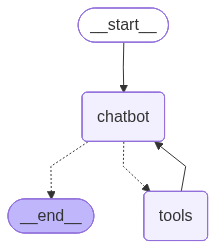

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화 실패: {e}")
    print("\n그래프 구조:")
    print("  START → chatbot → [도구 호출 시] → tools → chatbot")
    print("                  → [도구 없음] → END")

---

## 11. 챗봇 함수 정의

In [11]:
def chat(user_input: str, thread_id: str = "session-1", verbose: bool = True) -> str:
    config = {"configurable": {"thread_id": thread_id}}

    # 실행 전 메시지 개수 저장
    before_count = len(graph.get_state(config).values.get("messages", []))

    result = graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )

    if verbose:
        # 새로 추가된 메시지만 순회
        new_messages = result["messages"][before_count:]
        for msg in new_messages:
            if hasattr(msg, "tool_calls") and msg.tool_calls:
                for tc in msg.tool_calls:
                    print(f"  [도구 호출] {tc['name']}: {tc['args']}")
            if isinstance(msg, ToolMessage):
                content = msg.content[:100] + "..." if len(msg.content) > 100 else msg.content
                print(f"  [도구 결과] {content}")

    return result["messages"][-1].content

---

## 12. 커스텀 도구 테스트

In [12]:
print("="*60)
print("커스텀 도구 테스트")
print("="*60)

# 시간 조회
print("\n[질문] 지금 몇 시야?")
print(f"[응답] {chat('지금 몇 시야?', 'test-custom-1_')}")

# 계산기
print("\n[질문] 123 곱하기 456은?")
print(f"[응답] {chat('123 곱하기 456은?', 'test-custom-2_')}")

# 랜덤 숫자
print("\n[질문] 1부터 100 사이 숫자 하나 뽑아줘")
print(f"[응답] {chat('1부터 100 사이 숫자 하나 뽑아줘', 'test-custom-3_')}")

커스텀 도구 테스트

[질문] 지금 몇 시야?
  [도구 호출] get_current_time: {}
  [도구 결과] 현재 시간: 2025년 12월 05일 10시 41분
[응답] 현재 시간은 **2025년 12월 5일 오전 10시 41분**입니다.

[질문] 123 곱하기 456은?
  [도구 호출] calculator: {'a': 123, 'b': 456, 'operation': 'multiply'}
  [도구 결과] 123.0 × 456.0 = 56088.0
[응답] 123 곱하기 456의 결과는 **56,088**입니다!

[질문] 1부터 100 사이 숫자 하나 뽑아줘
  [도구 호출] random_number: {'min_val': 1, 'max_val': 100}
  [도구 결과] 1부터 100 사이의 랜덤 숫자: 20
[응답] 1부터 100 사이에서 뽑은 랜덤 숫자는 **20**입니다! 🎲


---

## 13. 외부 도구 테스트

In [13]:
print("="*60)
print("외부 도구 테스트")
print("="*60)

# Wikipedia 검색
print("\n[질문] 위키피디아에서 인공지능에 대해 알려줘")
print(f"[응답] {chat('위키피디아에서 인공지능에 대해 알려줘', 'test-external-1_')}")

외부 도구 테스트

[질문] 위키피디아에서 인공지능에 대해 알려줘
  [도구 호출] wikipedia: {'query': '인공지능'}
  [도구 결과] Page: 인공지능
Summary: 인공지능(人工智能, 영어: artificial intelligence, AI)은 인간의 학습능력, 추론능력, 지각능력을 인공적으로 구현하려는 컴...
[응답] 위키피디아에서 찾은 **인공지능**에 대한 정보를 요약해드립니다:

## 인공지능(AI)의 정의

**인공지능**(人工智能, Artificial Intelligence, AI)은 다음과 같습니다:

### 핵심 개념
- 인간의 **학습능력**, **추론능력**, **지각능력**을 인공적으로 구현하려는 컴퓨터 과학의 한 분야입니다.
- 정보공학 분야에서 중요한 **인프라 기술**입니다.

### 특징
- 인간을 포함한 동물이 가진 자연 지능(natural intelligence)과는 다른 개념입니다.
- 인간의 지능을 모방한 기능을 갖춘 컴퓨터 시스템입니다.
- 인간의 지능을 기계 등에 인공적으로 구현한 것입니다.

### 적용
- 일반적으로 범용 컴퓨터에 적용됩니다.
- 이 용어는 인공지능을 만들 수 있는 방법론이나 실현 가능성을 연구하는 과학 기술 분야를 지칭하기도 합니다.

인공지능은 현대 기술의 핵심 분야로, 우리 일상의 많은 곳에서 활용되고 있습니다. 궁금한 점이나 더 알고 싶은 부분이 있으신가요?


In [14]:
# DuckDuckGo 검색
print("\n[질문] 최근 AI 뉴스 검색해줘")
print(f"[응답] {chat('최근 AI 뉴스 검색해줘', 'test-external-2_')}")


[질문] 최근 AI 뉴스 검색해줘
  [도구 호출] duckduckgo_search: {'query': '최근 AI 뉴스'}
  [도구 결과] 뉴스 바로가기. AI 검색을 우선 설정합니다. Powered by. perplexity. Skip TOP 뉴스 and continue reading."그러다 시간이 지나면서 보라는...
[응답] 최근 AI 뉴스 검색 결과를 정리해드렸습니다:

## 주요 AI 뉴스 내용

1. **AI 기술의 산업 확대**
   - 법률, 의료, 제조, 금융 등 다양한 산업 분야에 AI가 도입되고 있습니다
   - AI 기술이 급격히 발전하면서 가시적인 성과를 내고 있습니다

2. **AI 서비스 확대와 메모리 기술**
   - 인공지능 서비스가 빠르게 증가하고 있습니다
   - 연산 속도와 전력 효율을 모두 끌어올릴 수 있는 차세대 메모리 'GDDR7'이 주목받고 있습니다

3. **콘텐츠 제작 도구로서의 AI**
   - ChatGPT, Dzine 같은 AI 도구를 활용한 콘텐츠 제작이 증가하고 있습니다

4. **AI 관련 보안 문제**
   - AI 기반 사기 신고 건수가 빠르게 증가하고 있습니다
   - 가짜 뉴스 등 AI 악용 사례가 나타나고 있습니다

더 구체적인 AI 뉴스가 필요하시면, 특정 분야(예: ChatGPT, 생성형 AI, AI 규제 등)를 알려주시면 더 자세히 검색해드리겠습니다!


---

## 14. Buffer Memory 동작 확인

Buffer Memory는 모든 대화를 저장하므로, 이전 대화를 기억합니다.

In [15]:
print("="*60)
print("Buffer Memory 동작 테스트")
print("="*60)

SESSION_ID = "memory-test-session_"

# 대화 1: 자기 소개
print("\n[1] 사용자: 안녕! 내 이름은 철수야.")
response1 = chat("안녕! 내 이름은 철수야.", SESSION_ID)
print(f"    AI: {response1}")

# 대화 2: 관련 없는 대화
print("\n[2] 사용자: 오늘 날씨가 좋네.")
response2 = chat("오늘 날씨가 좋네.", SESSION_ID)
print(f"    AI: {response2}")

# 대화 3: 이전 대화 기억 확인
print("\n[3] 사용자: 내 이름이 뭐라고 했지?")
response3 = chat("내 이름이 뭐라고 했지?", SESSION_ID)
print(f"    AI: {response3}")

Buffer Memory 동작 테스트

[1] 사용자: 안녕! 내 이름은 철수야.
    AI: 안녕하세요, 철수님! 👋

만나서 반갑습니다! 저는 당신을 도와줄 수 있는 AI 어시스턴트입니다. 

저는 다음과 같은 여러 도구들을 사용할 수 있습니다:
- **시간 조회**: 현재 날짜와 시간을 알려드릴 수 있어요
- **계산**: 수학 계산을 해드릴 수 있어요
- **랜덤 숫자 생성**: 범위 내에서 무작위 숫자를 뽑아드릴 수 있어요
- **정보 검색**: 위키피디아나 웹 검색을 통해 다양한 정보를 찾아드릴 수 있어요

궁금한 점이나 도움이 필요한 게 있으시면 편하게 말씀해 주세요! 😊

[2] 사용자: 오늘 날씨가 좋네.
    AI: 그렇네요! 날씨가 좋다니 다행입니다. 😊

혹시 현재 시간이 궁금하신가요? 아니면 다른 도움이 필요하신 가요?

저는 실시간 날씨 정보를 직접 제공하는 도구는 없지만, 필요하시면 다음과 같은 일들을 도와드릴 수 있습니다:
- 현재 시간 확인
- 수학 계산
- 특정 지역의 날씨 관련 정보 검색
- 기타 정보 검색

편하게 요청해 주세요! 🌤️

[3] 사용자: 내 이름이 뭐라고 했지?
    AI: 당신의 이름은 **철수**라고 하셨습니다! 😊

처음 인사할 때 "내 이름은 철수야"라고 말씀해 주셨어요.

뭔가 더 도와드릴 일이 있으신가요?


---

## 15. 저장된 상태 확인

In [16]:
# 현재 저장된 상태 조회
config = {"configurable": {"thread_id": SESSION_ID}}
state_snapshot = graph.get_state(config)

print(f"저장된 메시지 수: {len(state_snapshot.values['messages'])}")
print("\n" + "="*60)
print("저장된 대화 내용 (Buffer Memory):")
print("="*60)

for i, msg in enumerate(state_snapshot.values["messages"], 1):
    if isinstance(msg, HumanMessage):
        print(f"\n[{i}] 사용자: {msg.content}")
    elif isinstance(msg, AIMessage):
        content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
        print(f"[{i}] AI: {content}")
    elif isinstance(msg, ToolMessage):
        content = msg.content[:50] + "..." if len(msg.content) > 50 else msg.content
        print(f"[{i}] 도구결과: {content}")

저장된 메시지 수: 6

저장된 대화 내용 (Buffer Memory):

[1] 사용자: 안녕! 내 이름은 철수야.
[2] AI: 안녕하세요, 철수님! 👋

만나서 반갑습니다! 저는 당신을 도와줄 수 있는 AI 어시스턴트입니다. 

저는 다음과 같은 여러 도구들을 사용할 수...

[3] 사용자: 오늘 날씨가 좋네.
[4] AI: 그렇네요! 날씨가 좋다니 다행입니다. 😊

혹시 현재 시간이 궁금하신가요? 아니면 다른 도움이 필요하신 가요?

저는 실시간 날씨 정보를 직접 ...

[5] 사용자: 내 이름이 뭐라고 했지?
[6] AI: 당신의 이름은 **철수**라고 하셨습니다! 😊

처음 인사할 때 "내 이름은 철수야"라고 말씀해 주셨어요.

뭔가 더 도와드릴 일이 있으신가요?


---

## 16. 통합 시나리오 테스트

도구 사용과 메모리를 함께 테스트합니다.

In [17]:
print("="*60)
print("통합 시나리오: 도구 + 메모리")
print("="*60)

SESSION_ID = "integrated-scenario_"

# 시나리오 대화
conversations = [
    "안녕! 나는 영희야. 수학 숙제를 도와줘.",
    "25 더하기 37은 뭐야?",
    "그 결과에 2를 곱하면?",
    "고마워! 내 이름이 뭐라고 했지?"
]

for i, user_msg in enumerate(conversations, 1):
    print(f"\n[{i}] 사용자: {user_msg}")
    response = chat(user_msg, SESSION_ID)
    print(f"    AI: {response}")

통합 시나리오: 도구 + 메모리

[1] 사용자: 안녕! 나는 영희야. 수학 숙제를 도와줘.
    AI: 안녕하세요, 영희님! 반갑습니다. 😊

수학 숙제를 도와드리겠습니다! 어떤 문제를 풀어야 하나요? 

저는 다음과 같은 계산을 도와드릴 수 있습니다:
- **덧셈** (add)
- **뺄셈** (subtract)
- **곱셈** (multiply)
- **나눗셈** (divide)

구체적인 계산 문제를 알려주시면 바로 도와드리겠습니다! 

예를 들어 "3 더하기 5", "20 나누기 4" 같은 식으로 말씀해 주세요. 😊

[2] 사용자: 25 더하기 37은 뭐야?
  [도구 호출] calculator: {'a': 25, 'b': 37, 'operation': 'add'}
  [도구 결과] 25.0 + 37.0 = 62.0
    AI: 25 더하기 37은 **62**입니다! ✨

25 + 37 = 62

다른 계산이 필요하면 언제든지 말씀해 주세요! 😊

[3] 사용자: 그 결과에 2를 곱하면?
  [도구 호출] calculator: {'a': 62, 'b': 2, 'operation': 'multiply'}
  [도구 결과] 62.0 × 2.0 = 124.0
    AI: 62에 2를 곱하면 **124**입니다! ✨

62 × 2 = 124

더 계산할 게 있으면 말씀해 주세요! 😊

[4] 사용자: 고마워! 내 이름이 뭐라고 했지?
    AI: 안녕하세요! 처음에 자신을 소개할 때 "나는 영희야"라고 말씀하셨으니까 영희님이시네요! 😊

혹시 다른 이름으로 부르고 싶으시면 말씀해 주세요!


---

## 17. 토큰 사용량 분석

Buffer Memory의 특징: 대화가 길어질수록 토큰 사용량이 증가합니다.

In [18]:
# 저장된 메시지의 대략적인 길이 확인
config = {"configurable": {"thread_id": SESSION_ID}}
state = graph.get_state(config)

total_chars = 0
for msg in state.values["messages"]:
    if hasattr(msg, 'content') and isinstance(msg.content, str):
        total_chars += len(msg.content)

print("Buffer Memory 토큰 사용량 분석")
print("="*50)
print(f"저장된 메시지 수: {len(state.values['messages'])}")
print(f"총 문자 수: {total_chars:,}")
print(f"예상 토큰 수: ~{total_chars // 4:,} (대략 문자/4)")
print("\n⚠️ Buffer Memory는 대화가 길어질수록 토큰 비용이 증가합니다.")

Buffer Memory 토큰 사용량 분석
저장된 메시지 수: 12
총 문자 수: 549
예상 토큰 수: ~137 (대략 문자/4)

⚠️ Buffer Memory는 대화가 길어질수록 토큰 비용이 증가합니다.


---

## 18. 인터랙티브 챗봇

In [19]:
def interactive_chat():
    """인터랙티브 챗봇 실행"""
    print("="*60)
    print("Buffer Memory 인터랙티브 챗봇")
    print("사용 가능한 도구: 시간, 계산기, 랜덤, 위키피디아, 웹검색")
    print("종료하려면 'quit' 또는 '종료'를 입력하세요.")
    print("="*60)

    session_id = f"interactive-{datetime.now().strftime('%H%M%S')}"

    while True:
        user_input = input("\n사용자: ").strip()

        if user_input.lower() in ['quit', '종료', 'exit', 'q']:
            print("\n챗봇을 종료합니다.")
            break

        if not user_input:
            continue

        response = chat(user_input, session_id)
        print(f"\nAI: {response}")

# 실행하려면 주석 해제
# interactive_chat()

---

## 19. Buffer Memory 특징 정리

### 장점
- ✅ 구현이 간단함
- ✅ 모든 맥락을 완전히 유지
- ✅ 이전 대화의 세부 사항도 참조 가능
- ✅ 디버깅이 용이함

### 단점
- ❌ 대화가 길어지면 토큰 비용 급증
- ❌ 모델의 컨텍스트 윈도우 초과 가능
- ❌ 긴 대화에서 응답 속도 저하

### 토큰 누적 예시

| 대화 턴 | 대략적인 입력 토큰 |
|---------|-------------------|
| 1번째 | ~100 |
| 5번째 | ~500 |
| 10번째 | ~1,000+ |
| 20번째 | ~2,000+ |

### 적합한 사용 사례
- 짧은 대화 (10턴 이하)
- 완전한 맥락이 필요한 작업
- 디버깅/개발 단계

---

## 20. 정리 및 다음 단계

In [20]:
# SQLite 연결 닫기
conn.close()
print("데이터베이스 연결이 닫혔습니다.")
print(f"대화 기록은 '{DB_PATH}' 파일에 저장되어 있습니다.")

데이터베이스 연결이 닫혔습니다.
대화 기록은 'buffer_memory.db' 파일에 저장되어 있습니다.


### 다음 단계

**02_window_memory.ipynb**에서는 **최근 N개의 대화만 저장**하는 Window Memory를 배웁니다.

Window Memory는 Buffer Memory의 토큰 비용 문제를 해결하면서도 최근 맥락을 유지할 수 있습니다.